In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
torch.manual_seed(200)

In [17]:
df = pd.read_csv("/content/data.txt", sep = "\t")
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

In [18]:
X_train= (X_train-X_train.mean(axis=0))/X_train.std(axis=0)

In [21]:
X_train.shape

(20, 2)

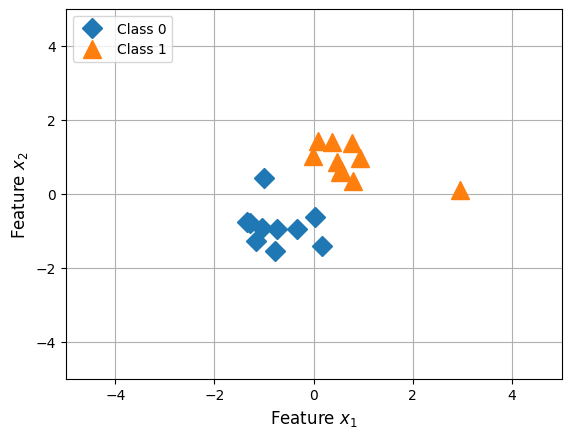

In [19]:
plt.plot(
  X_train[y_train == 0, 0],
  X_train[y_train == 0, 1],
  marker = "D",
  markersize = 10,
  linestyle = "",
  label = "Class 0"
)

plt.plot(
  X_train[y_train == 1, 0],
  X_train[y_train == 1, 1],
  marker = "^",
  markersize = 13,
  linestyle = "",
  label = "Class 1"
)

plt.legend(loc = 2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize = 12)
plt.ylabel("Feature $x_2$", fontsize = 12)

plt.grid()
plt.show()

In [20]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.linear = torch.nn.Linear(num_features, 1)

  def forward(self, x):
    output=self.linear(x)
    sigmoid=torch.sigmoid(output)
    return sigmoid


In [22]:
logreg=LogisticRegression(X_train.shape[1])

In [23]:
x = torch.tensor([1.1, 2.1])

In [24]:
logreg(x)

tensor([0.7006], grad_fn=<SigmoidBackward0>)

In [25]:
# Disable the construction of computation graph in the background
with torch.no_grad():
  pred = logreg(x)

print(pred)

tensor([0.7006])


# loading the data, cause we banned numpy

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [31]:
class MyDataset(Dataset):
  def __init__(self, x, y):
    self.features = torch.tensor(x, dtype = torch.float32)
    self.labels = torch.tensor(y, dtype = torch.float32)

  def __getitem__(self, idx):
    x = self.features[idx]
    y = self.labels[idx]

    return x, y

  def __len__(self):
    return self.labels.shape[0]

In [32]:
train_ds = MyDataset(X_train, y_train)

train_loader = DataLoader(
  dataset = train_ds,
  batch_size = 10,
  shuffle = True
)

In [39]:
epochs=50
model=LogisticRegression(X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [40]:
for epoch in range(epochs):
  model = model.train()

  for batch_idx, (features, labels) in enumerate(train_loader):
    probas = model(features)
    loss = F.binary_cross_entropy(probas, labels.view(probas.shape))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    print(f'Epochs: {epoch + 1:03d}/{epochs:03d}'
          f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
          f' | Loss: {loss:.2f}')

Epochs: 001/050 | Batch 000/002 | Loss: 0.79
Epochs: 001/050 | Batch 001/002 | Loss: 0.83
Epochs: 002/050 | Batch 000/002 | Loss: 0.92
Epochs: 002/050 | Batch 001/002 | Loss: 0.63
Epochs: 003/050 | Batch 000/002 | Loss: 0.74
Epochs: 003/050 | Batch 001/002 | Loss: 0.74
Epochs: 004/050 | Batch 000/002 | Loss: 0.71
Epochs: 004/050 | Batch 001/002 | Loss: 0.71
Epochs: 005/050 | Batch 000/002 | Loss: 0.71
Epochs: 005/050 | Batch 001/002 | Loss: 0.65
Epochs: 006/050 | Batch 000/002 | Loss: 0.66
Epochs: 006/050 | Batch 001/002 | Loss: 0.63
Epochs: 007/050 | Batch 000/002 | Loss: 0.65
Epochs: 007/050 | Batch 001/002 | Loss: 0.59
Epochs: 008/050 | Batch 000/002 | Loss: 0.63
Epochs: 008/050 | Batch 001/002 | Loss: 0.56
Epochs: 009/050 | Batch 000/002 | Loss: 0.53
Epochs: 009/050 | Batch 001/002 | Loss: 0.62
Epochs: 010/050 | Batch 000/002 | Loss: 0.58
Epochs: 010/050 | Batch 001/002 | Loss: 0.52
Epochs: 011/050 | Batch 000/002 | Loss: 0.58
Epochs: 011/050 | Batch 001/002 | Loss: 0.49
Epochs: 01

In [41]:
def compute_accuracy(model, dataloader):
  model = model.eval()
  correct = 0.0
  total_examples = 0

  for idx, (features, labels) in enumerate(dataloader):
    with torch.no_grad():
      probas = model(features)

    pred = torch.where(probas > 0.5, 1, 0)
    lab = labels.view(pred.shape).to(pred.dtype)

    compare = lab == pred
    correct += torch.sum(compare)
    total_examples += len(compare)

  return correct / total_examples

In [42]:
train_acc = compute_accuracy(model, train_loader)
print(f'Accuracy: {train_acc * 100}%')

Accuracy: 100.0%


In [43]:
def plot_boundary(model):
  w1 = model.linear.weight[0][0].detach()
  w2 = model.linear.weight[0][1].detach()
  b = model.linear.bias[0].detach()

  x1_min = -20
  x2_min = (-(w1 * x1_min) - b) / w2

  x1_max = 20
  x2_max = (-(w1 * x1_max) - b) / w2

  return x1_min, x1_max, x2_min, x2_max

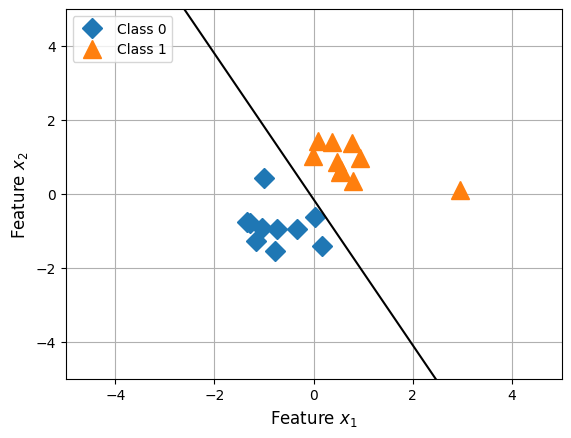

In [44]:
x1_min, x1_max, x2_min, x2_max = plot_boundary(model)


plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.plot([x1_min, x1_max], [x2_min, x2_max], color="k")

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()